In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
from gymnasium.wrappers import RecordVideo
import optuna
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from datetime import datetime

In [5]:

from custom_PPO.PPOAgent import PPOAgent


def optimize_ppo(trial):
    # Create the CartPole-v1 environment
    env = gym.make("CartPole-v1", render_mode="rgb_array")  # Set render_mode to rgb_array
    # Define the hyperparameters search space
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.99)
    eps_clip = trial.suggest_float("eps_clip", 0.1, 0.3)
    ppo_epochs = trial.suggest_int("ppo_epochs", 3, 10)
    entropy_beta = trial.suggest_float("entropy_beta", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)
    buffer_size = trial.suggest_int("buffer_size", batch_size * 10, batch_size * 20, step=batch_size)
    time_horizon = trial.suggest_int("time_horizon", 64, 2048, step=64)
    hidden_units = trial.suggest_int("hidden_units", 32, 512, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    max_steps = trial.suggest_int("max_steps", 500_000, 1_000_000, step=100_000)
    normalize = trial.suggest_categorical("normalize", [True, False])

    # Adjust environment observation normalization
    if normalize:
        env = gym.wrappers.TransformObservation(env, lambda obs: (obs - obs.mean()) / (obs.std() + 1e-8),
                                                observation_space=env.observation_space)
    # Initialize PPO agent with current hyperparameters
    agent = PPOAgent(
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.n,
        lr=lr,
        gamma=gamma,
        eps_clip=eps_clip,
        batch_size=batch_size,
        ppo_epochs=ppo_epochs,
        entropy_beta=entropy_beta,
        buffer_size=buffer_size,
        max_steps=max_steps,
        hidden_units=hidden_units,
        num_layers=num_layers,
    )

    reward_history = []  # Track rewards for each episode

    for episode in range(50):
        states, actions, rewards, dones, old_probs = [], [], [], [], []
        state, _ = env.reset()  # Reset the environment
        total_reward = 0

        for _ in range(time_horizon):  # Use time_horizon from search space
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = agent.policy(state_tensor).detach().numpy()
            action = np.random.choice(env.action_space.n, p=action_probs)

            new_state, reward, done, truncated, _ = env.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done or truncated)
            old_probs.append(action_probs[action])

            state = new_state
            total_reward += reward

            if done or truncated:
                break

        # Train the agent after each episode with the collected experience
        agent.train((states, actions, rewards, dones, old_probs))

        reward_history.append(total_reward)  # Append the total reward

    # Return mean reward over the episodes
    return np.mean(reward_history)

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=100)

# Print the Best Hyperparameters
print("Best Hyperparameters:")
print(study.best_params)

[I 2024-12-05 18:42:05,503] A new study created in memory with name: no-name-d3fdfac8-8418-4341-b09d-6ae4f7cada10
[I 2024-12-05 18:42:10,356] Trial 0 finished with value: 49.14 and parameters: {'learning_rate': 4.065198085643451e-05, 'gamma': 0.9252523234695155, 'eps_clip': 0.20733984639466696, 'ppo_epochs': 6, 'entropy_beta': 0.002238445489237908, 'batch_size': 352, 'buffer_size': 4576, 'time_horizon': 768, 'hidden_units': 256, 'num_layers': 2, 'max_steps': 600000, 'normalize': True}. Best is trial 0 with value: 49.14.
[I 2024-12-05 18:42:12,601] Trial 1 finished with value: 55.5 and parameters: {'learning_rate': 5.017340211532322e-05, 'gamma': 0.9625113834165415, 'eps_clip': 0.20845898376360097, 'ppo_epochs': 4, 'entropy_beta': 0.0002378585173792746, 'batch_size': 288, 'buffer_size': 3744, 'time_horizon': 576, 'hidden_units': 512, 'num_layers': 2, 'max_steps': 700000, 'normalize': False}. Best is trial 1 with value: 55.5.
[I 2024-12-05 18:42:14,732] Trial 2 finished with value: 91.88

Best Hyperparameters:
{'learning_rate': 0.0004815130482187222, 'gamma': 0.9819418901639946, 'eps_clip': 0.28439112968248903, 'ppo_epochs': 10, 'entropy_beta': 0.0028675675332428202, 'batch_size': 288, 'buffer_size': 3168, 'time_horizon': 1344, 'hidden_units': 352, 'num_layers': 2, 'max_steps': 1000000, 'normalize': False}


In [7]:
# Run the Optuna Optimization
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Train the Agent with the Best Hyperparameters
best_params = study.best_params
agent = PPOAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=best_params["learning_rate"],
    gamma=best_params["gamma"],
    eps_clip=best_params["eps_clip"],
    batch_size=best_params["batch_size"],
    ppo_epochs=best_params["ppo_epochs"],
    entropy_beta=best_params["entropy_beta"],
    buffer_size=best_params["buffer_size"],  # Include buffer_size
    max_steps=best_params["max_steps"],      # Include max_steps
    hidden_units=best_params["hidden_units"],  # Include hidden_units
    num_layers=best_params["num_layers"],    # Include num_layers
)


reward_history = []
episodes = 10000

for episode in range(episodes):
    states, actions, rewards, dones, old_probs = [], [], [], [], []
    state, _ = env.reset()
    total_reward = 0

    for t in range(best_params["buffer_size"]):  # Use time_horizon from best_params here
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = agent.policy(state_tensor).detach().numpy()
        action = np.random.choice(env.action_space.n, p=action_probs)

        new_state, reward, done, truncated, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done or truncated)
        old_probs.append(action_probs[action])

        state = new_state
        total_reward += reward

        if done or truncated:
            break

    agent.train((states, actions, rewards, dones, old_probs))
    reward_history.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")


Episode 1: Total Reward = 20.0
Episode 51: Total Reward = 167.0
Episode 101: Total Reward = 157.0
Episode 151: Total Reward = 185.0
Episode 201: Total Reward = 500.0
Episode 251: Total Reward = 228.0
Episode 301: Total Reward = 261.0
Episode 351: Total Reward = 500.0
Episode 401: Total Reward = 162.0
Episode 451: Total Reward = 293.0
Episode 501: Total Reward = 112.0
Episode 551: Total Reward = 500.0
Episode 601: Total Reward = 500.0
Episode 651: Total Reward = 122.0
Episode 701: Total Reward = 243.0
Episode 751: Total Reward = 90.0
Episode 801: Total Reward = 122.0
Episode 851: Total Reward = 500.0
Episode 901: Total Reward = 296.0
Episode 951: Total Reward = 500.0
Episode 1001: Total Reward = 500.0
Episode 1051: Total Reward = 115.0
Episode 1101: Total Reward = 216.0
Episode 1151: Total Reward = 500.0
Episode 1201: Total Reward = 500.0
Episode 1251: Total Reward = 500.0
Episode 1301: Total Reward = 471.0
Episode 1351: Total Reward = 500.0
Episode 1401: Total Reward = 475.0
Episode 14

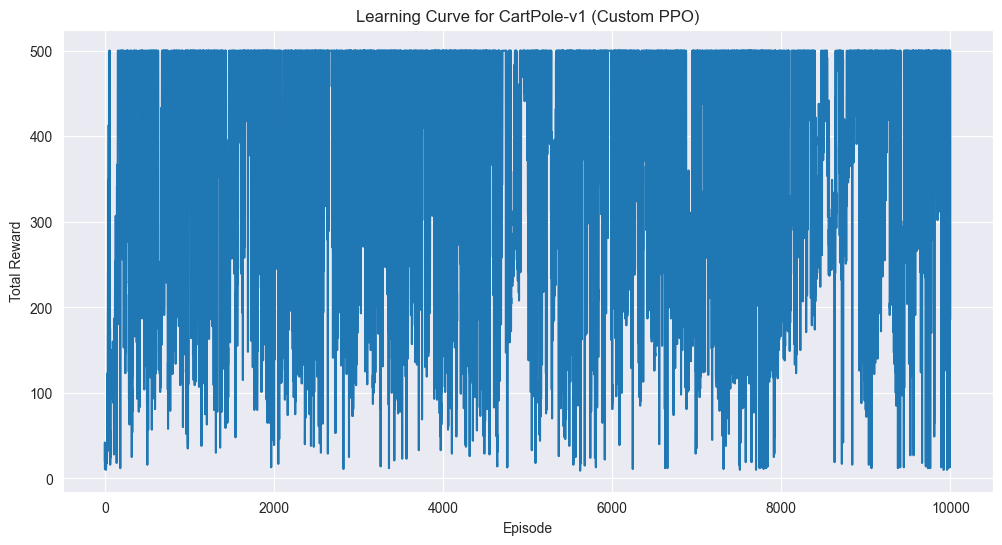

In [11]:
# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve for CartPole-v1 (Custom PPO)")
plt.grid(True)
plt.show()


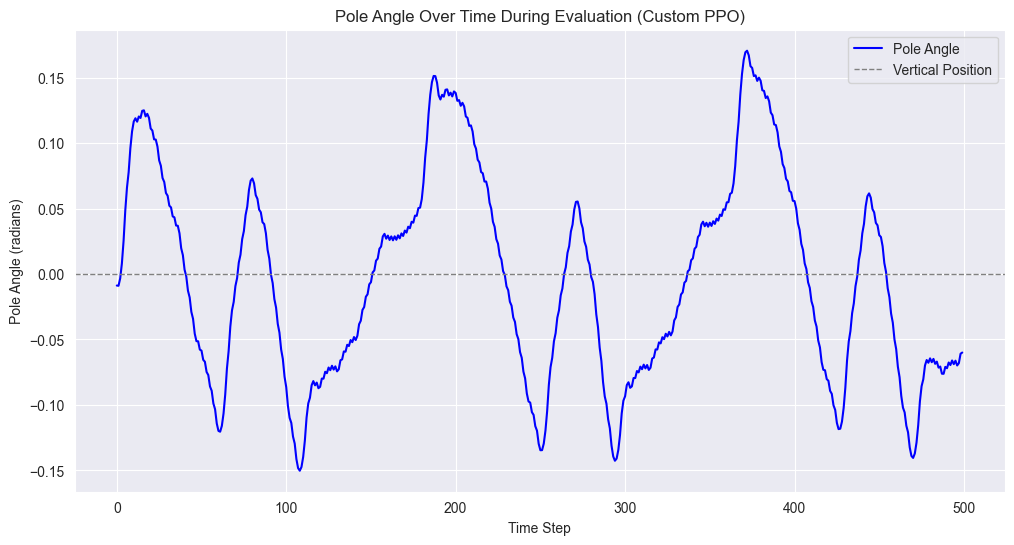

In [12]:
# Run evaluation
eval_env = gym.make("CartPole-v1", render_mode="rgb_array")

state, _ = eval_env.reset()
done = False
state_trajectory = []

while not done:
    state_trajectory.append(state)  # Record the state for pole angle analysis

    # Convert state to tensor and get action probabilities
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Ensure batch dimension
    action_probs = agent.policy(state_tensor).detach().numpy()

    # Choose an action (stochastic sampling or deterministic)
    action = np.argmax(action_probs.squeeze())  # Deterministic action

    # Step in the environment
    state, reward, done, truncated, _ = eval_env.step(action)

    # Check if it's a terminal state
    done = done or truncated

# Close the environment after recording
eval_env.close()

# Extract Pole Angles from State Trajectory
pole_angles = [s[2] for s in state_trajectory]  # Assuming state[2] is the pole angle

# Plot Pole Angle Over Time During Evaluation
plt.figure(figsize=(12, 6))
plt.plot(range(len(pole_angles)), pole_angles, label='Pole Angle', color='b')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label="Vertical Position")
plt.xlabel('Time Step')
plt.ylabel('Pole Angle (radians)')
plt.title('Pole Angle Over Time During Evaluation (Custom PPO)')
plt.legend()
plt.grid(True)
plt.show()
